In [1]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import requests

import math
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, LogNormal


from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions.bernoulli import Bernoulli

import IsoDatasets
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from collections import defaultdict




import gzip
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


/zhome/8a/8/181201/Prediction-of-protein-isoforms-using-semi-supervised-learning/venv_iso/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Init Code

In [8]:
def load_data_chunk(filename, chunk_size=1000):
    """ Load a chunk of data from a gzipped TSV file. """
    return pd.read_csv(filename, sep='\t', compression='gzip', chunksize=chunk_size)

def separate_ids_and_data(data):
    ids = data.iloc[:, 0]
    data = data.iloc[:, 1:]
    return ids, data

def create_data_loaders(data_dir, batch_size, train_percent=0.8, load_in_mem=False):
    full_dataset = IsoDatasets.Archs4GeneExpressionDataset(data_dir, load_in_mem)
    train_size = int(train_percent * len(full_dataset))
    test_size = len(full_dataset) - train_size

    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


def plot_line(tensor, axs, line_width=1.0):
    # Check if the input is a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        # Check if the tensor is on a CUDA device and move it to CPU if necessary
        if tensor.is_cuda:
            tensor = tensor.cpu()

        # Convert the Torch tensor to a NumPy array
        numeric_array = tensor.detach().numpy()
    else:
        # If it's not a tensor, assume it's already a NumPy array
        numeric_array = tensor

    # Plotting code remains the same
    axs.plot(numeric_array, linewidth=line_width)
    axs.set_title('Gene Expression Profile')
    axs.set_xlabel('Gene Index')
    axs.set_ylabel('Expression Level')

# Kaiming initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

def is_nan(tensor):
    """ Check if a tensor is NaN """
    return torch.isnan(tensor).any()


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()

    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()

    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()

    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        # z = mu + sigma * epsilon
        return self.mu + self.sigma * self.sample_epsilon()

    def log_prob(self, z: Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        # Log probability for Gaussian distribution
        # log p(z) = -1/2 * [log(2*pi) + 2*log(sigma) + (z - mu)^2/sigma^2]
        return -0.5 * (torch.log(2 * torch.tensor(math.pi)) + 2 * torch.log(self.sigma) +
                       torch.pow(z - self.mu, 2) / torch.pow(self.sigma, 2))
    
    def count_csv_rows(filename):
        # If the file is gzip-compressed, decompress it first
        if filename.endswith('.gz'):
            with gzip.open(filename, 'rt', newline='') as csvfile:
                row_count = sum(1 for row in csvfile)
        else:
            # Specify the correct encoding (e.g., 'utf-8', 'latin-1', etc.)
            encoding = 'utf-8'  # Change to the appropriate encoding if needed
            with open(filename, 'r', newline='', encoding=encoding) as csvfile:
                row_count = sum(1 for row in csvfile)
        return row_count

# Define the file paths
archs4_path = "/dtu-compute/datasets/iso_02456/archs4_gene_expression_norm_transposed.tsv.gz"
gtex_gene_path = "/dtu-compute/datasets/iso_02456/gtex_gene_expression_norm_transposed.tsv.gz"
gtex_isoform_path = "/dtu-compute/datasets/iso_02456/gtex_isoform_expression_norm_transposed.tsv.gz"
gtex_anno_path = "/dtu-compute/datasets/iso_02456/gtex_gene_isoform_annoation.tsv.gz"
gtex_tissue_path = "/dtu-compute/datasets/iso_02456/gtex_annot.tsv.gz"

# hdf5 paths:
archs4_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/archs4_gene_expression_norm_transposed.hdf5"
gtex_gene_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_gene_expression_norm_transposed.hdf5"
gtex_isoform_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_isoform_expression_norm_transposed.hdf5"

num_genes = 18965
num_isoforms = 156958

num_genes, num_isoforms

archs4_train_dataloader, archs4_test_dataloader = create_data_loaders(
    "/dtu-compute/datasets/iso_02456/hdf5/",
    batch_size=64,
    train_percent=0.8,
    load_in_mem=False  # Set to False to avoid MemoryError
)

genes = next(iter(archs4_train_dataloader))
print(genes.shape)
genes[0]

class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """

    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()

        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)


        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features), # <- note the 2*latent_features
            nn.ReLU(),
        )

        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )

        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""

        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)

        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)

        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_params = self.decoder(z)
        px_params = px_params.view(-1, *self.input_shape) # reshape the output
        return LogNormal(px_params, 1.0) # Assuming variance of 1


    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""

        # flatten the input
        x = x.view(x.size(0), -1)

        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)

        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))

        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}


    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""

        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)

        # sample the prior
        z = pz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta

    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:

        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))

        # compute the ELBO with and without the beta parameter:
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta * kl # <- your code here

        # loss
        loss = -beta_elbo.mean()

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}

        return loss, diagnostics, outputs
    

# input_shape = vae.input_shape
input_shape = torch.Size([18965])
input_shape

print(torch.__version__)
print(torch.version.cuda)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
    

# Load desired VAE

In [13]:
# Load the model from a file
vae = VariationalAutoencoder(genes[0].shape, 500) # second parameter is number of latent features that the model whas trained on (backed up model is 100)
vae.load_state_dict(torch.load('models/vae_LF_500_Epochs_10.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

# Convert gene to latent space

In [20]:
Zs = []

# Example of making a training set that excludes samples from the brain and a test set with only samples from the brain
# If you have enough memory, you can load the dataset to memory using the argument load_in_mem=True
gtex_train = IsoDatasets.GtexDataset("/dtu-compute/datasets/iso_02456/hdf5/", exclude='brain')
gtex_test = IsoDatasets.GtexDataset("/dtu-compute/datasets/iso_02456/hdf5/", include='brain')

print("gtex training set size:", len(gtex_train))
print("gtex test set size:", len(gtex_test))

gtx_train_dataloader = DataLoader(gtex_train, batch_size=64, shuffle=False)
gtx_test_dataloader = DataLoader(gtex_test, batch_size=64, shuffle=False)

for x, y in tqdm(gtx_train_dataloader):
    x = x.to(device)

    # Forward pass through the VAE
    outputs = vae(x)
    z = outputs['z'].cpu().detach().numpy() # z is the latent space
    Zs.append(z)

gtex training set size: 14714
gtex test set size: 2642


100%|██████████| 42/42 [01:11<00:00,  1.70s/it]


In [27]:
# Concatenate the list of z values into a single array. Otherwise it separates by batches
Zs = np.concatenate(Zs, axis=0)

# The shape of Zs will be [total_num_batches * batch_size, latent_features]
print("Shape of Zs:", Zs.shape)

Shape of Zs: (2642, 500)


# Old Code

In [14]:
# Sample from the prior
sampled_data = vae.sample_from_prior(batch_size=10)
generated_samples = sampled_data['px'].mean  # Assuming Bernoulli distribution

generated_samples.shape


torch.Size([10, 18965])

In [15]:
# Sample a batch from your data
x = next(iter(test_loader))
x = x.to(device)

# Forward pass through the VAE
outputs = vae(x)
z = outputs['z'].cpu().detach().numpy() # z is the latent space
print(f"Latent space size: {z.shape[1]}")
print(z.shape)

Latent space size: 500
(64, 500)


In [16]:
# Forward pass through the VAE
reconstructed_data = outputs['px'].mean  # Assuming Bernoulli distribution

# Compare original 'x' and 'reconstructed_data' visually or with a metric
reconstructed_data.shape

torch.Size([64, 18965])

### Plot VAE data

Generated Gene VS Real Gene

In [17]:

def plot_line(tensor, axs, title, xlabel, ylabel, line_width=1.0,):
    # Check if the input is a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        # Check if the tensor is on a CUDA device and move it to CPU if necessary
        if tensor.is_cuda:
            tensor = tensor.cpu()

        # Convert the Torch tensor to a NumPy array
        numeric_array = tensor.detach().numpy()
    else:
        # If it's not a tensor, assume it's already a NumPy array
        numeric_array = tensor

    # Plotting code remains the same
    axs.plot(numeric_array, linewidth=line_width)
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)

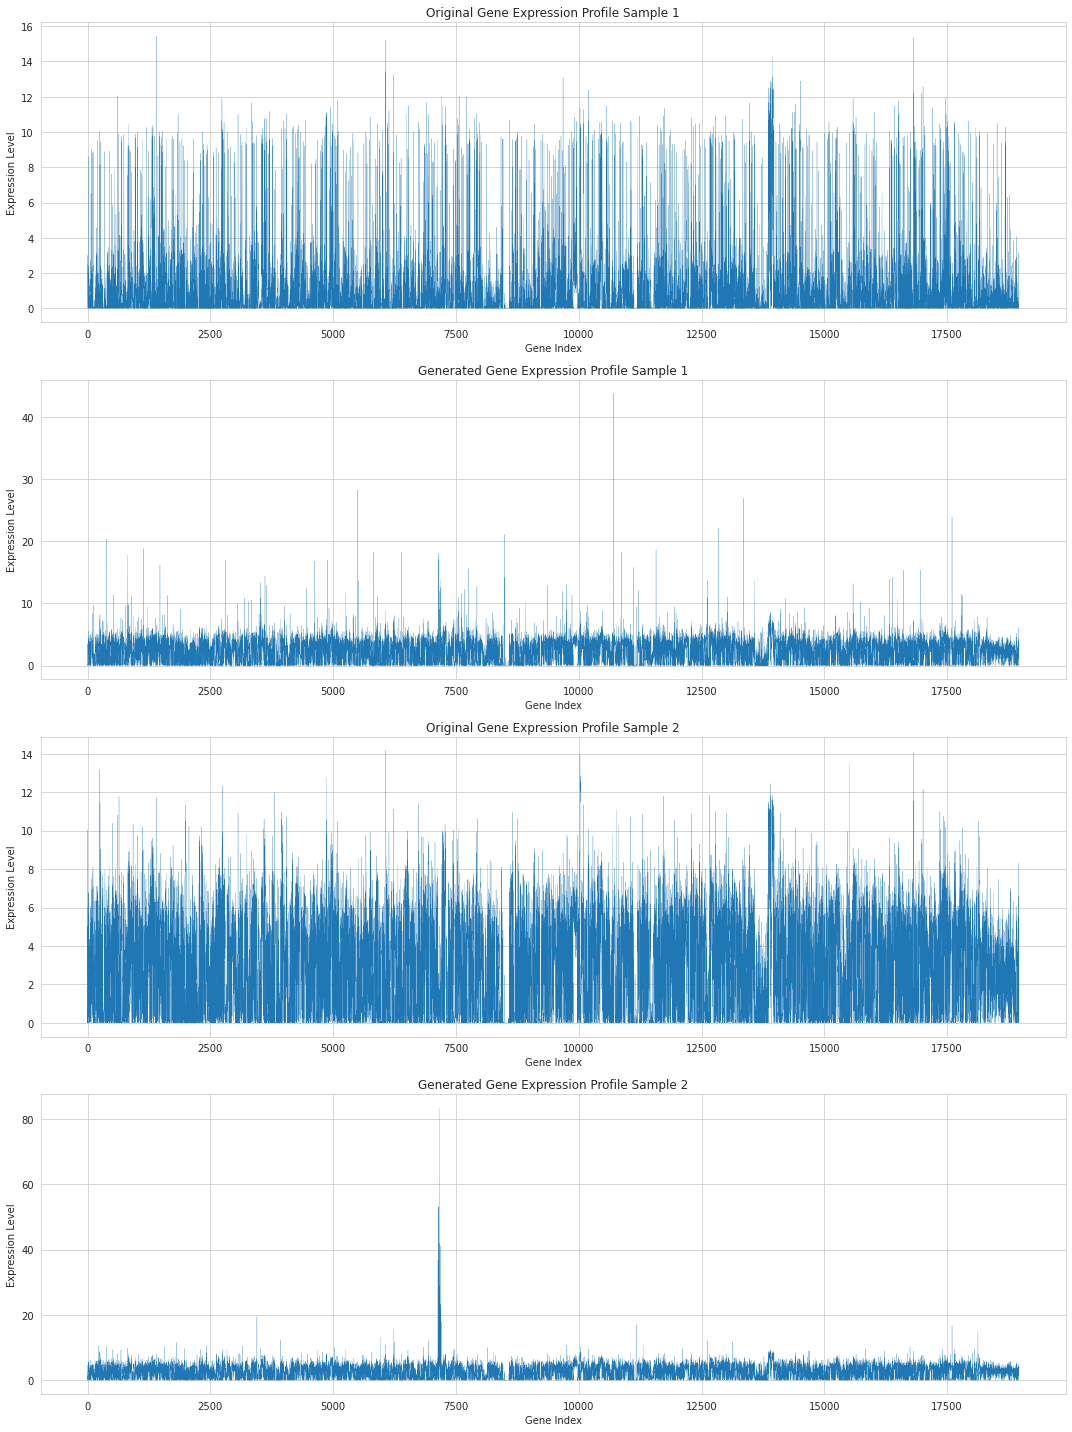

In [18]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(4, 1, figsize=(15, 20))  # 4 rows, 1 column

# Plot each line on its respective subplot
plot_line(genes[0], axs[0], title='Original Gene Expression Profile Sample 1', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)
plot_line(reconstructed_data[0], axs[1], title='Generated Gene Expression Profile Sample 1', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)
plot_line(genes[1], axs[2], title='Original Gene Expression Profile Sample 2', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)
plot_line(reconstructed_data[1], axs[3], title='Generated Gene Expression Profile Sample 2', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

We can see that our model generates genes with values that are wither 0 or 1, while a real gene have values that go from 0 to 14. Further steps include checking that model architecture is correct, and improve model by augmenting latent space and epochs.

Latent space sample

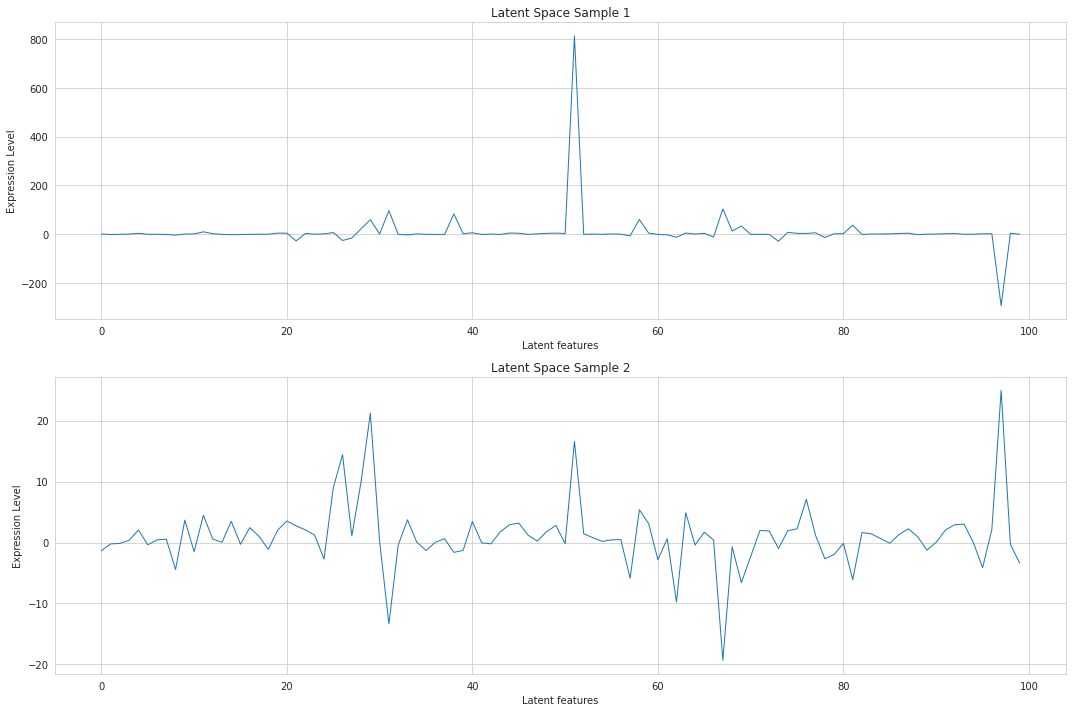

In [45]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))  # 2 rows, 1 column

# Plot each line on its respective subplot
plot_line(z[0], axs[0], title='Latent Space Sample 1', xlabel='Latent features', ylabel='Expression Level', line_width=1)
plot_line(z[1], axs[1], title='Latent Space Sample 2', xlabel='Latent features', ylabel='Expression Level', line_width=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Analyzing the VAE



### Exercise 3.

**Experiment with the VAE model.**

1. Experiment with the number of layers and activation functions in order to improve the reconstructions and latent representation. What solution did you find the best and why?
3. Increase the number of units in the latent layer. Does it increase the models representational power and how can you see and explain this? How does this affect the quality of the reconstructions?

**Answers**:

1. We tried going deeper by adding 1 and 2 layers without seeing much difference. However, if we go shallower by removing one layer both the reconstruction and generative results get worse, though we can still recongnize some digits.
As for the activation functions we tried LeakyRelu with pretty much the same results, maybe slightly worst. The plots are available at the end of the notebook.
3. Increasing the number of units in the latent layer to 4 improved the model reconstruction and generation capabilities, where it still has some trouble differentiating between 9 and 4 but it performs better than before. This happens because when we increase the units, the latent space becomes capable of capturing more complex patterns and nuances in the data.

### Exercise 4.

**Analyze the purpose of the KL-term and the $\beta$ parameter.**

1. How does the KL-term, $\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$, work as a regulariser on the distributions over latent variables? *HINT*: When maximising the ELBO, the probability-distance measure is minimised $\operatorname{KL} \rightarrow 0$ so that $q(z|x) \rightarrow p(z) = \mathcal{N}(z|0,I)$ for all examples, x. At $\operatorname{KL} = 0$ variations in x stops having an affect on the latent distribution and latent units are all described by the same distribution, $\mathcal{N}(z|0,I)$, so they produce a noisy output without signal (i.e. $\mathbf{z}=\epsilon \sim \mathcal{N}(0,I)$) to the decoder.
2. Try removing the KL-term (using the $\beta$ parameter) and analyze what happens during training, in the learning curves, latent representation and reconstructions compared to before removing it.
3. What does the loss reduces to? Explain how this can affect a VAE. *HINT*: Compare loss function for AE and VAE, and remember that we can use the pixel-wise binary crossentropy error as the loss in the AEs and for the reconstruction error, $\log p_\theta(\mathbf{x}|\mathbf{z}) = \log \mathcal{B}(\mathbf{x} | g_\theta(z))$, in VAEs.
4. Experiment with different $\beta$ values (e.g. [0.1, 10, 50]) and explain how this affects the reconstruction quality and the latent representations. *HINT* what is the tradeoff between reconstruction error ($\log p_\theta(\mathbf{x} | \mathbf{z})$) and the KL term?

**Answers**:

1. The KL-term, measures the divergence between two distributions: the approximate posterior and the prior, which is typically a standard normal distribution N(0,I). As the ELBO is maximized, the KL-term aims to be minimized. When it reaches 0, it indicates that the approximate posterior is the same as the prior. This means that the latent variables are not being influenced by the input data x and are essentially just noise sampled from N(0,I). Thus, the KL-term acts as a regularizer by ensuring that the latent representations don't stray too far from a prior belief (which is the standard normal distribution in most VAEs). Without this term, the latent variables might fit too closely to the training data, leading to overfitting.
2. By removing the KL-term (setting $\beta$=0), the VAE doesn't have any regularization on the latent space. This means the model focuses solely on the reconstruction error. We can observe:
 - The latent representation is probably more overfitted to the training data.
 - The reconstructions might be sharper initially but could lead to overfitting, where it performs well on training data but poorly on unseen data.  
 Also for this part we experimented errors during the execution, only for beta=0. When we went above 40 epochs, most of the times we got a Cuda error that can be seen in the Annex. Not sure of why this happens and if the student reading this have any idea I would appreciate the feedback.  
3. Without the KL-term, the VAE loss reduces to just the reconstruction error. In this scenario, the VAE becomes more like a traditional autoencoder (AE). This can lead to overfitting more easily just like an AE.  
4. We can see the following differences:
 - A smaller $\beta$ (e.g., 0.1): Puts less emphasis on the KL-term, leading to better reconstructions but poorer generalization and more complex latent representations.
 - $\beta$ =1: This is the standard VAE, which balances reconstruction with regularization from the KL-term.
 - A larger $\beta$ (e.g., 10, 50): Puts more emphasis on the KL-term, leading to simpler latent representations but potentially worse reconstructions. But for $\beta$=50 specifically, both reconstructions and generations are diffuse and bad.

 The trade-off is that As $\beta$ increases, the model prioritizes making the approximate posterior close to the prior, often at the expense of reconstruction quality. Conversely, as $\beta$ decreases, the model prioritizes reconstruction, potentially at the expense of generalization.

